# GPT BLOCK

In [1]:
import torch.nn as nn
import torch

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # SPLIT THE DMODEL - WORD EMB VECTOR BY # HEADS, SO EACH HEAD GET EQ LEN VEC

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # ROWS OF INPUT = num_tokens , NUMBER OF TOKENS
        # COLUMNS OF INPUT = DMODEL , EMBEDDING VEC DIMEN
        # NOW MANY BATCH OF X*Y

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        
        #tensor.view(a, b, c, d) only reshapes the underlying memory without copying or splitting anything.
        # REFER TO IMAGE 1
        
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        # this is grouping the values by heads SO THAT WE CAN COMPUTE THE HEADS SEPARATELY & PARALELLY
        # REFER TO IMAGE 2
        
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # REFER TO IMAGE 3
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        # REFER TO IMAGE 4
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # REFER TO IMAGE 5
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        # REFER TO IMAGE 6
        #important -  here we are bringing back the matrix into image 1 format so that we can concat
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
         # REFER TO IMAGE 7
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [3]:
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [4]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [5]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x  # step 1 : keep a backup of the original input
        x = self.norm1(x) # step 2 : normalize the input embeddings
        x = self.att(x)  # step 3 : add contextual embeddings through Multihead attention
        x = self.drop_shortcut(x) # step 4 : Turn off the embeddings activations 
        x = x + shortcut  # step 5:  Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x # step 6 : keep a new backup of the input processed till now
        x = self.norm2(x)  # step 7 : normalize the input embeddings
        x = self.ff(x) # step 8 : feed forward network to expand and contract
        x = self.drop_shortcut(x) # step 9 : Turn off the embeddings activations 
        x = x + shortcut  #step 10 Add the original input back

        return x

In [7]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [8]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [9]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)


In [10]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [11]:
out = model(batch)

In [12]:
print("\nOutput shape:", out.shape)


Output shape: torch.Size([2, 4, 50257])


In [13]:
out

tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)

In [14]:
# 2 batches
# Input:   Every | effort | moves | you
# Target:  effort | moves | you | <next_token>

# Token 0 (“Every”) attends only to itself - logits[0, 0, :] - distribution for the next token after "Every"
# Token 1 (“effort”) attends to: “Every”, “effort” -logits[0, 1, :] -  distribution after "effort"
# Token 2 (“moves”) attends to: “Every”, “effort”, “moves” - logits[0, 2, :] = distribution after "moves"
# Token 3 (“you”) attends to: “Every”, “effort”, “moves”, “you”  -  logits[0, 3, :] = distribution after "you" (the final next-token prediction)



# Inference -  GPT

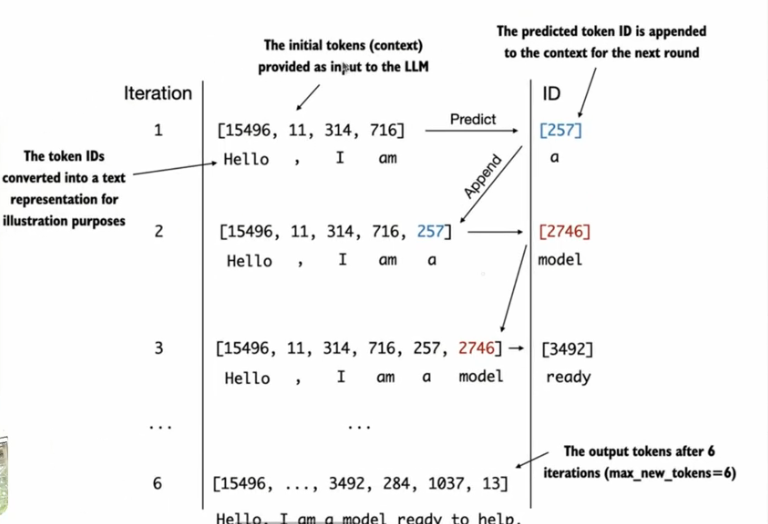

In [15]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

out = model(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [16]:
out

tensor([[[ 0.2158,  0.8098, -0.0785,  ...,  0.3044,  0.0925, -0.4206],
         [ 0.4778, -0.1980, -0.7204,  ...,  0.2929,  0.4723, -0.3468],
         [ 0.5839,  0.1771,  0.2777,  ...,  0.1819, -0.1629,  0.1456],
         [-1.1075,  0.1911,  0.1088,  ...,  1.2593,  0.1811, -0.2607]],

        [[-0.0796,  0.1565, -0.2127,  ...,  0.1772,  0.0053, -0.2903],
         [ 0.0412,  0.0072, -0.2995,  ...,  0.6002,  0.0643,  0.0536],
         [ 1.0808,  0.9359, -0.6385,  ...,  0.6433,  0.6054,  0.0751],
         [ 0.1112,  0.2752,  0.3173,  ...,  0.9636, -0.0160, -0.4464]]],
       grad_fn=<UnsafeViewBackward0>)

In [21]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens): # MAXIMUM ITERATION OF THE PREDICTIONS
        
 
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:] # SETTING THE CONTEXT WINDOW
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) 
            #PASSING THE INPUTS THROUGH THE MODEL
            #DIMENSION= BATCH, NTOKENS , VOCAB SIZE PREDICTION
            
        # EXTRACT only on the last time step , THE LAST TIMESTEP HAS SEEN ALL THE WORDS AND CAPTURED THE WHOLE SENSE
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities TO GET PROBABLITY OF BEST TOKEN FROM  - VOCAB SIZE PREDICTION
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [18]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [22]:
model.eval() #A
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [23]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


## IMPORTANT
in practice, the softmax step is redundant since the position with the highest score in the softmax output tensor is the same position in the logit tensor.
In other words, we could apply the torch.argmax function to the logits tensor directly and get identical results.
However, we coded the conversion to illustrate the full process of transforming logits to probabilities, which can add additional intuition, such as that the model generates the most likely next token, which is known as greedy decoding.
we will also introduce additional sampling techniques where we modify the softmax outputs such that the model doesn't always select the most likely token, which introduces variability and creativity in the generated text.

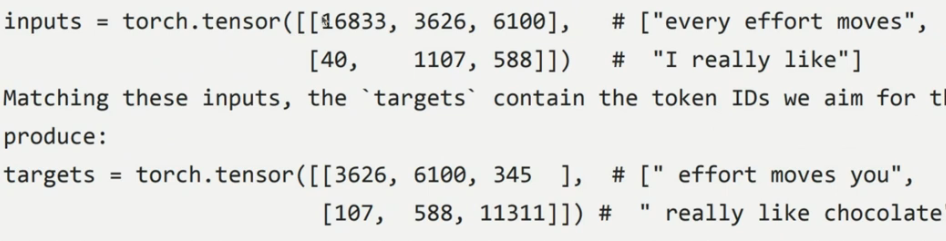

In [25]:
import torch
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]
with torch.no_grad():
    logits = model(inputs)

In [26]:
logits

tensor([[[-0.0755, -0.5548,  0.3469,  ...,  0.1516,  0.5015, -1.1592],
         [ 0.2559, -0.8154, -0.6564,  ..., -0.3625,  0.3844, -0.1579],
         [ 0.8914, -0.3270,  0.1289,  ...,  0.0780, -0.3120, -0.1173]],

        [[ 0.5330, -0.2724,  0.9216,  ..., -0.5423,  0.6964, -0.8690],
         [ 0.1810,  0.3803,  0.1456,  ..., -1.0162,  0.6445, -0.2404],
         [ 0.6139,  0.1547,  0.3890,  ..., -0.2707, -0.1842,  0.2355]]])

In [27]:
probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [28]:
# probas[b, t, v] = probability of vocab token v at time-step t for batch b

tensor([[[1.5619e-05, 9.6721e-06, 2.3829e-05,  ..., 1.9601e-05,
          2.7812e-05, 5.2847e-06],
         [2.1799e-05, 7.4676e-06, 8.7542e-06,  ..., 1.1746e-05,
          2.4788e-05, 1.4412e-05],
         [4.0975e-05, 1.2116e-05, 1.9115e-05,  ..., 1.8165e-05,
          1.2299e-05, 1.4943e-05]],

        [[2.8877e-05, 1.2905e-05, 4.2591e-05,  ..., 9.8521e-06,
          3.4002e-05, 7.1068e-06],
         [2.0209e-05, 2.4667e-05, 1.9506e-05,  ..., 6.1039e-06,
          3.2126e-05, 1.3260e-05],
         [3.1132e-05, 1.9669e-05, 2.4862e-05,  ..., 1.2855e-05,
          1.4016e-05, 2.1325e-05]]])

In [29]:
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [32]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

Text 1: tensor([2.3466e-05, 2.0531e-05, 1.1733e-05])
